# SkimLit exercises
Exercises from @mrdbourdke course, all solution are either code-alongs (if already created) or proposed my myself.

## Exercise 1
Train `model_5` from notebook 09 on all of the data in the training dataset as many epochs until it stops improving. Since this might take a while, consider using:
* `tf.keras.callbacks.ModelCheckpoint` to save weights of the best model trained
* `tf.keras.callbacks.EarlyStopping` to stop the model from training once the validation less has stopped improving for approx. 3 epochs

### Confirm GPU access

In [3]:
!nvidia-smi

Sun May  7 08:06:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Get the data

In [4]:
# Clone the GitHub repo and 
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [5]:
# Get the full, 200k dataset
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [6]:
# Check the filenames in the directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [7]:
# Download helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-05-07 08:06:11--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-05-07 08:06:11 (76.9 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [8]:
# Unzipping the data
#from helper_functions import unzip_data
#unzip_data("/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip")

### Preprocess the data

In [9]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (text file) and returns the lines of text as a list.

  Args:
    filename: string, contains the target filepath

  Returns:
    A list of strins with one string per line from the target filename
  """

  with open(filename, 'r') as f:
    return f.readlines()

In [10]:
# Reading in the training lines
train_lines = get_lines(data_dir + 'train.txt')
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [11]:
# Get the total number of lines
len(train_lines)

210040

In [12]:
# Function to preprocess the data to desired format
def preprocess_text_with_linenumbers(filename):
  """
  Returns a list of dictionaries of abstract RCT line data. Takes in the filename,
  reads its content and works through each line extracting all necessary data to
  be returned,

  Args:
    filename: string, contains a RCT data 

  Returns:
    abstract_samples: dictionary, with data such as 'target', 'text',
      'line_number' and 'total_lines' per each abstract
  """
  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"): # check for the ID of an abastract
      abstract_id = line
      abstract_lines = "" # reset the abstract string so it's empty for new one

    elif line.isspace(): # check if the line is the new line
      abstract_line_split = abstract_lines.splitlines() # split the lines into new lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split the text from the target label
        line_data['target'] = target_text_split[0] # get the target label
        line_data['text'] = target_text_split[1].lower() # get the text in lowered version
        line_data['line_number'] = abstract_line_number # get the number of a particular line from enumerate operator
        line_data['total_lines'] = len(abstract_line_split)-1 # how many total lines are there in each abstract

        abstract_samples.append(line_data) # add the data to the samples list

    else: # if the above are not met, the line contains labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [13]:
# Get the data into the memory
%%time
train_samples = preprocess_text_with_linenumbers(data_dir + 'train.txt')
val_samples = preprocess_text_with_linenumbers(data_dir + 'dev.txt')
test_samples = preprocess_text_with_linenumbers(data_dir + 'test.txt')
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 411 ms, sys: 91.4 ms, total: 502 ms
Wall time: 501 ms


In [14]:
# Check the first samples from training data
train_samples[:15]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [15]:
# Placing the data in Pandas DataFrame
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(15)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


### Small portion of EDA

<Axes: >

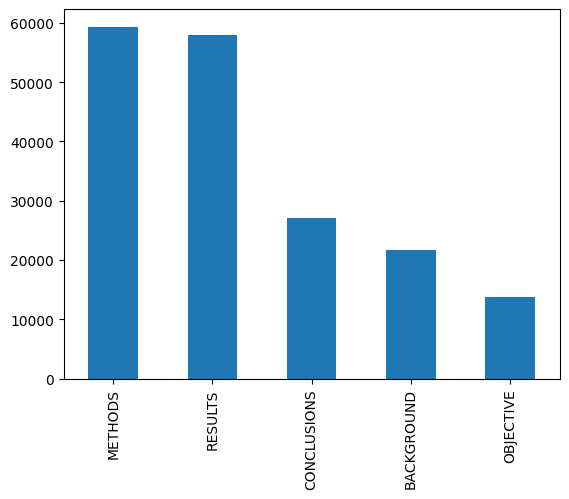

In [16]:
# Distribution of training labels
train_df['target'].value_counts().plot(kind='bar')

<Axes: ylabel='Frequency'>

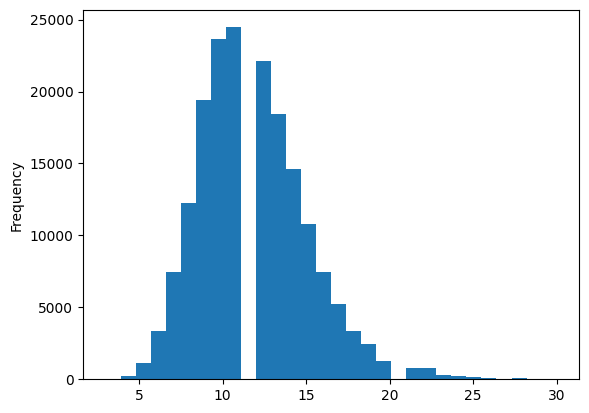

In [17]:
# Checking the number of lines per abstract
train_df.total_lines.plot.hist(bins=30)

### Getting the list of sentences

In [18]:
# Extracting the lines from DataFrames
train_sentences = train_df['text'].to_list()
val_sentences = val_df['text'].to_list()
test_sentences = test_df['text'].to_list()
print(len(train_sentences))

180040


### Encode the labels
Both one-hot-encoded and label encoded (numerical value)

In [19]:
# One-hot encode labels
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse_output=False)

train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.fit(test_df['target'].to_numpy().reshape(-1, 1))

# Check one set of labels
train_labels_one_hot[:20]

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [20]:
# Label encode labels (numerical values)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

# Check the labels
train_labels_encoded[:20]

array([3, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 1, 0, 0, 3, 3, 2, 2, 2, 4])

In [21]:
# Get class names and number of classes
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

### Create a character-level tokenizer

In [22]:
# Look again at the exemplary sentences
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [23]:
# Function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Check the function
import random
target_sentence = split_chars(random.choice(train_sentences))
split_chars(target_sentence)

'a   t       t   h   e       e   n   d       o   f       t   h   e       @   -   m   o   n   t   h       p   e   r   i   o   d       ,       i   n   c   r   e   a   s   e   s       i   n       l   -   b   m   d       w   e   r   e       s   i   m   i   l   a   r       b   e   t   w   e   e   n       g   r   o   u   p       @       (       @       %       )       a   n   d       g   r   o   u   p       @       (       @       %       )       ,       b   u   t       b   a   p   w   v       w   a   s       s   i   g   n   i   f   i   c   a   n   t   l   y       r   e   d   u   c   e   d       i   n       g   r   o   u   p       @       c   o   m   p   a   r   e   d       w   i   t   h       g   r   o   u   p       @       .'

In [24]:
# Split all the data into char tokens
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[1])

a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .


In [25]:
# Average char length
import numpy as np
char_len = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_len)
mean_char_len

149.3662574983337

(array([7.8590e+03, 3.5206e+04, 4.9626e+04, 4.0112e+04, 2.4025e+04,
        1.2206e+04, 5.8610e+03, 2.5790e+03, 1.2490e+03, 6.2200e+02,
        3.1400e+02, 1.5300e+02, 8.8000e+01, 5.1000e+01, 2.8000e+01,
        1.7000e+01, 1.7000e+01, 8.0000e+00, 5.0000e+00, 6.0000e+00,
        2.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00000000e+00, 4.71666667e+01, 9.33333333e+01, 1.39500000e+02,
        1.85666667e+02, 2.31833333e+02, 2.78000000e+02, 3.24166667e+02,
        3.70333333e+02, 4.16500000e+02, 4.62666667e+02, 5.08833333e+02,
        5.55000000e+02, 6.01166667e+02, 6.47333333e+02, 6.93500000e+02,
        7.39666667e+02, 7.85833333e+02, 8.32000000e+02, 8.78166667e+02,
        9.24333333e+02, 9.70500000e+02, 1.01666667e+03, 1.06283333e+03,
        1.10900000e+03, 1.15516667e+03, 1.20133333e+03, 1.24750000e+03,
        1.29366667e+03, 1.33983333e+03, 1.38600000e+03]),
 <BarContainer object of 30 

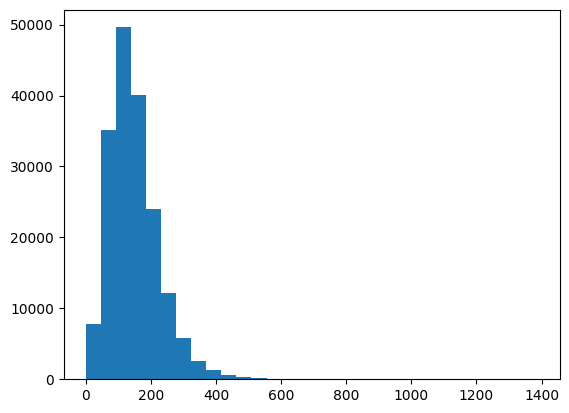

In [26]:
# Distribution of character level length
import matplotlib.pyplot as plt
plt.hist(char_len, bins=30)

In [27]:
# Check the 95 percentile
output_seq_char_len = int(np.percentile(char_len, 95))
output_seq_char_len

290

In [28]:
# Get all of the keyboard characters into one variable
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet, len(alphabet)

('abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~', 68)

In [29]:
# Create character-level token vectorizer instance
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
NUM_CHAR_TOKENS = len(alphabet)
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS+2,
                                    output_sequence_length=output_seq_char_len,
                                    standardize=None,
                                    name='char_vectorizer')

In [30]:
# Create another instance of dataset for adapting the layer
import tensorflow as tf
train_char_adapt = tf.data.Dataset.from_tensor_slices(train_chars).batch(128).prefetch(tf.data.AUTOTUNE)
train_char_adapt

<_PrefetchDataset element_spec=TensorSpec(shape=(None,), dtype=tf.string, name=None)>

In [31]:
# Adapt the layer to characters
%%time
char_vectorizer.adapt(train_char_adapt)

CPU times: user 3.72 s, sys: 386 ms, total: 4.11 s
Wall time: 2.81 s


In [32]:
# Check the vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of chars: {len(char_vocab)}")
print(f"Most popular chars: {char_vocab[:5]}")
print(f"Least popular chars: {char_vocab[-5:]}")

Number of chars: 57
Most popular chars: ['', '[UNK]', 'e', 't', 'i']
Least popular chars: ['|', '"', ']', '\\', '[']


In [33]:
# Test the layer
random_chars = random.choice(train_chars)
print(f"Random charred sentence:\n {random_chars}\n")
vectorized_chars = char_vectorizer(random_chars)
print(f"Vectorized, charred sentence:\n {vectorized_chars}\n")
print(f"Shape of vectorized, charred text:\n {vectorized_chars.shape}")

Random charred sentence:
 b l o o d   l a c t a t e   ,   e m g   f a t i g u e   ,   a n d   t h e   n u m b e r   o f   e l b o w   f l e x i o n - e x t e n s i o n   r e p e t i t i o n s   d u r i n g   t h e   f a t i g u e   p r o t o c o l   w e r e   u s e d   t o   e v a l u a t e   t h e   e f f e c t s   o f   l a s e r   t h e r a p y   (   @   n m   w a v e l e n g t h   ,   @   m w   o u t p u t   p o w e r   ,   p o w e r   d e n s i t y   o f   @   w / c m   (   @   )   ,   @   s e c   e a c h   p o i n t   a n d   @   j / p o i n t   o n   e i g h t   p o i n t s   )   .

Vectorized, charred sentence:
 [23 12  7  7 10 12  5 11  3  5  3  2 24  2 15 18 17  5  3  4 18 16  2 24
  5  6 10  3 13  2  6 16 15 23  2  8  7 17  2 12 23  7 21 17 12  2 30  4
  7  6 26  2 30  3  2  6  9  4  7  6  8  2 14  2  3  4  3  4  7  6  9 10
 16  8  4  6 18  3 13  2 17  5  3  4 18 16  2 14  8  7  3  7 11  7 12 21
  2  8  2 16  9  2 10  3  7  2 22  5 12 16  5  3  2  3 13  2  2 17 17  2
 11  3 

### Character-level embedding layer

In [34]:
# Create embedding layer
char_embed = tf.keras.layers.Embedding(input_dim=len(char_vocab), # number of different chars
                                       output_dim=25, # as stated in the paper
                                       mask_zero=True,
                                       name='char_embed')

In [35]:
# Test the layer
print(f"Charred text:\n {random_chars}\n")
embedded_chars = char_embed(vectorized_chars)
print(f"Vectorized, embedded charred text:\n {embedded_chars}\n")
print(f"Shape of the output:\n {embedded_chars.shape}")

Charred text:
 b l o o d   l a c t a t e   ,   e m g   f a t i g u e   ,   a n d   t h e   n u m b e r   o f   e l b o w   f l e x i o n - e x t e n s i o n   r e p e t i t i o n s   d u r i n g   t h e   f a t i g u e   p r o t o c o l   w e r e   u s e d   t o   e v a l u a t e   t h e   e f f e c t s   o f   l a s e r   t h e r a p y   (   @   n m   w a v e l e n g t h   ,   @   m w   o u t p u t   p o w e r   ,   p o w e r   d e n s i t y   o f   @   w / c m   (   @   )   ,   @   s e c   e a c h   p o i n t   a n d   @   j / p o i n t   o n   e i g h t   p o i n t s   )   .

Vectorized, embedded charred text:
 [[-0.00137402  0.04972769 -0.03115967 ... -0.03655317 -0.00279377
   0.0424471 ]
 [ 0.04850573  0.02666842  0.02908674 ... -0.0231366   0.02754091
  -0.01320041]
 [-0.0011429   0.03808321  0.04227081 ...  0.01383908  0.0409061
  -0.01041567]
 ...
 [-0.04119812 -0.02715585 -0.04658126 ... -0.01939526 -0.02580874
   0.03571686]
 [-0.04119812 -0.02715585 -0.04658126 ... -0.01939

### Create positional embeddings

In [36]:
# Check how many different line numbers are in the dataset
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

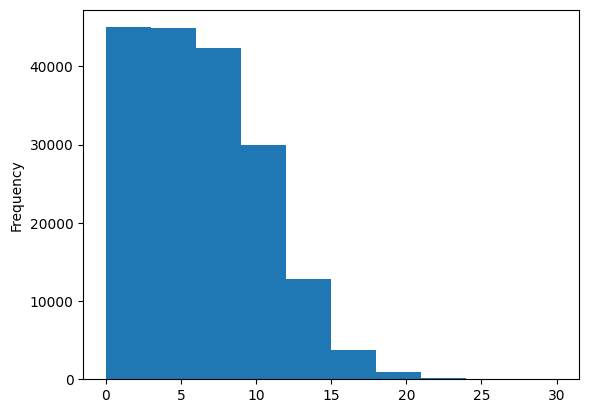

In [37]:
# Plot the distribution
train_df.line_number.plot.hist()

In [38]:
# Check the 98th percentile
line_number_depth = int(np.percentile(train_df['line_number'], 98))
line_number_depth

15

In [39]:
# One hot encode the data
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'], depth=line_number_depth)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'], depth=line_number_depth)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'], depth=line_number_depth)
train_line_numbers_one_hot[:15]

<tf.Tensor: shape=(15, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [40]:
# Now onto the total_lines...
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

<Axes: ylabel='Frequency'>

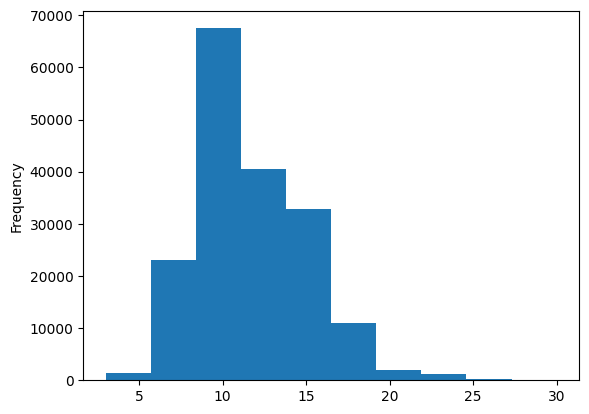

In [41]:
# Distribution
train_df['total_lines'].plot.hist()

In [42]:
# 98th percentile
total_lines_depth = int(np.percentile(train_df['total_lines'], 98))
total_lines_depth

20

In [43]:
# One hot encode the features
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'], depth=total_lines_depth)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'], depth=total_lines_depth)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'], depth=total_lines_depth)
train_total_lines_one_hot[:15]

<tf.Tensor: shape=(15, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
     

### Get a Universal Sentence Encoder layer ftom TF Hub

In [44]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name='universal_sentence_encoder')

### Build a model
At last, after all this preparation...

In [45]:
# 1. Token inputs
token_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name='token_inputs')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = tf.keras.layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line number inputs
line_number_inputs = tf.keras.layers.Input(shape=(15,), dtype=tf.float32, name='line_number_input')
line_number_outputs = tf.keras.layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=line_number_outputs)

# 4. Total lines inputs
total_lines_inputs = tf.keras.layers.Input(shape=(20,), dtype=tf.float32, name='total_lines_input')
total_lines_outputs = tf.keras.layers.Dense(32, activation='relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=total_lines_outputs)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = tf.keras.layers.Concatenate(name='char_token_embedding')([char_model.output,
                                                                                token_model.output])
combined_dense = tf.keras.layers.Dense(256, activation='relu')(combined_embeddings)
combined_dropout = tf.keras.layers.Dropout(0.5)(combined_dense)

# 6. Triple embedding with line number, total lines and combined char&token embeddings
triple_embedding = tf.keras.layers.Concatenate(name='triple_embedding')([line_number_model.output,
                                                                         total_lines_model.output,
                                                                         combined_dropout])

# 7. Create the final output layer
output_layer = tf.keras.layers.Dense(5, activation='softmax', name='output_layer')(triple_embedding)

# 8. Put the model together
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 char_model.input,
                                 token_model.input],
                         outputs=output_layer,
                         name='triple_embedding_model')

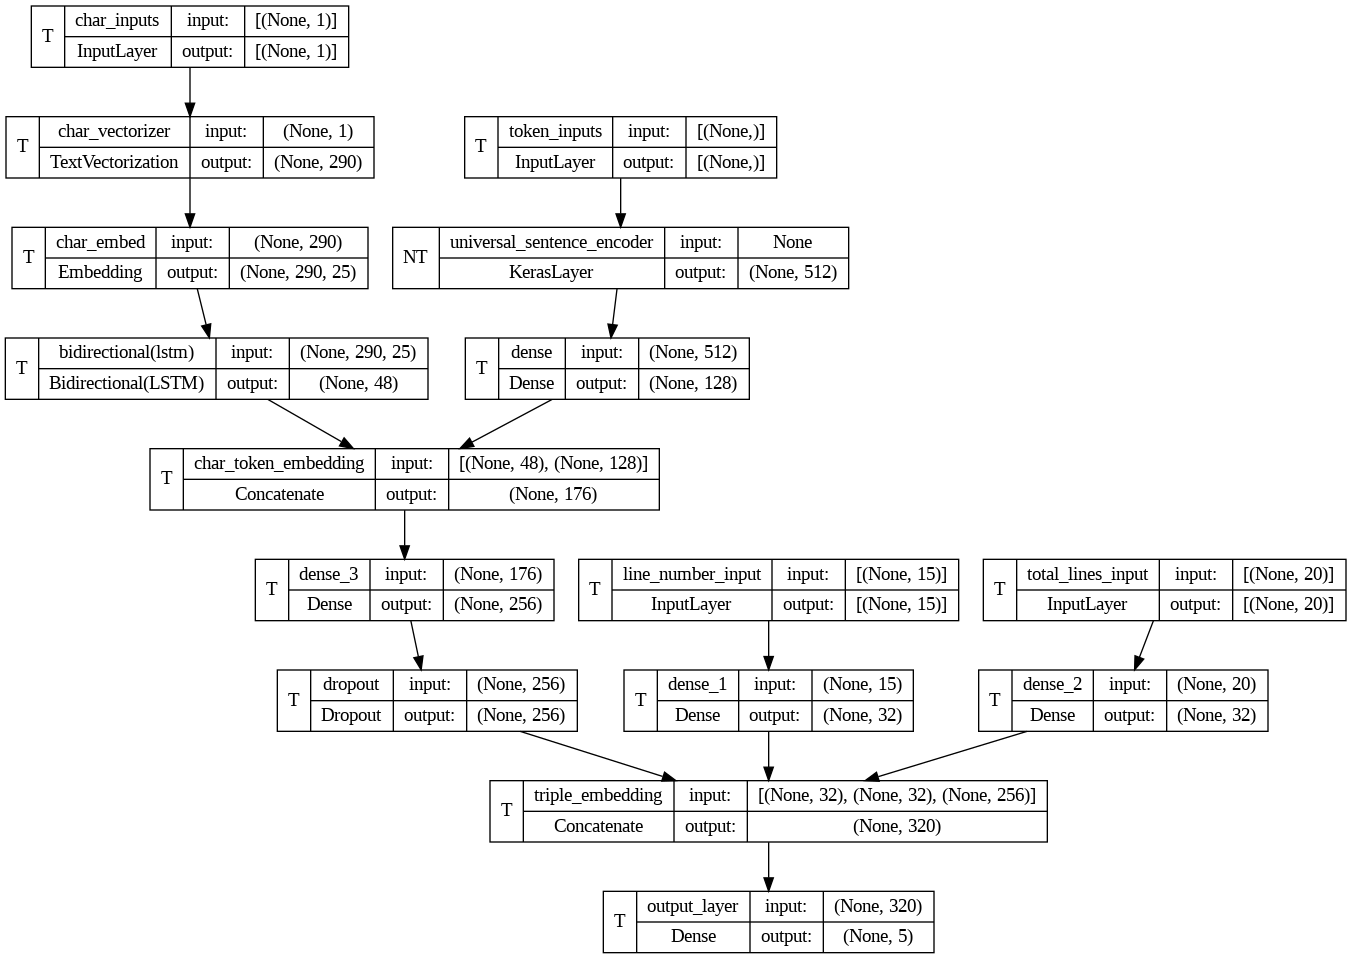

In [46]:
# Plot the architecture
tf.keras.utils.plot_model(model_5,
                          show_shapes=True,
                          show_trainable=True)

In [47]:
# Check the summary of the model
model_5.summary()

Model: "triple_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_embed (Embedding)         (None, 290, 25)      1425        ['char_vecto

### Prepare datasets for the model

In [48]:
# Train dataset
train_ln_tl_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                  train_total_lines_one_hot,
                                                                  train_chars,
                                                                  train_sentences))
train_ln_tl_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_ln_tl_char_token_dataset = tf.data.Dataset.zip((train_ln_tl_char_token_data,
                                                      train_ln_tl_char_token_labels))
train_ln_tl_char_token_dataset = train_ln_tl_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_ln_tl_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [49]:
# Validation dataset
val_ln_tl_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                                val_total_lines_one_hot,
                                                                val_chars,
                                                                val_sentences))
val_ln_tl_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_ln_tl_char_token_dataset = tf.data.Dataset.zip((val_ln_tl_char_token_data,
                                                    val_ln_tl_char_token_labels))
val_ln_tl_char_token_dataset = val_ln_tl_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_ln_tl_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Create the callbacks
More specifically: ModelCheckpoint and EarlyStopping.

In [50]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model_checkpoint = ModelCheckpoint(filepath="model_5_ckpt",
                                   monitor='val_loss',
                                   verbose=1,
                                   save_weights_only=True,
                                   save_freq='epoch')

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=3,
                               verbose=1,
                               restore_best_weights=True,
                               start_from_epoch=3)

### Compile the model

In [ ]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.SGD(),
                metrics=['accuracy'])

In [ ]:
history_model_5 = model_5.fit(train_ln_tl_char_token_dataset,
                              #steps_per_epoch=int(0.1*len(train_ln_tl_char_token_dataset)),
                              epochs=25,
                              validation_data=val_ln_tl_char_token_dataset,
                              validation_steps=int(0.1*len(val_ln_tl_char_token_dataset)),
                              callbacks=[model_checkpoint,
                                         early_stopping])

Epoch 1/25
5626/5627 [============================>.] - ETA: 0s - loss: 0.8446 - accuracy: 0.9002
Epoch 1: saving model to model_5_ckpt
5627/5627 [==============================] - 219s 36ms/step - loss: 0.8446 - accuracy: 0.9002 - val_loss: 0.8813 - val_accuracy: 0.8650
Epoch 2/25
5627/5627 [==============================] - ETA: 0s - loss: 0.8423 - accuracy: 0.9014
Epoch 2: saving model to model_5_ckpt
5627/5627 [==============================] - 199s 35ms/step - loss: 0.8423 - accuracy: 0.9014 - val_loss: 0.8808 - val_accuracy: 0.8657
Epoch 3/25
5627/5627 [==============================] - ETA: 0s - loss: 0.8413 - accuracy: 0.9027
Epoch 3: saving model to model_5_ckpt
5627/5627 [==============================] - 201s 36ms/step - loss: 0.8413 - accuracy: 0.9027 - val_loss: 0.8808 - val_accuracy: 0.8660
Epoch 4/25
5627/5627 [==============================] - ETA: 0s - loss: 0.8408 - accuracy: 0.9029
Epoch 4: saving model to model_5_ckpt
5627/5627 [==============================] - 203

In [ ]:
# Adam optimizer metrics
print(f'Evaluation results:\n {model_5.evaluate(val_ln_tl_char_token_dataset)}')
preds_adam = tf.argmax(model_5.predict(val_ln_tl_char_token_dataset), axis=1)

from helper_functions import calculate_results
results_adam = calculate_results(y_true=val_labels_encoded,
                                 y_pred=preds_adam)

print(f'Calculated Adam results:')
results_adam

945/945 [==============================] - 23s 24ms/step - loss: 0.8873 - accuracy: 0.8628
Evaluation results:
 [0.8873068690299988, 0.8628028631210327]
945/945 [==============================] - 17s 18ms/step
Calculated Adam results:



{'accuracy': 86.28028597908116,
 'precision': 0.8633113519609606,
 'recall': 0.8628028597908116,
 'f1': 0.8602664183128899}

In [ ]:
# SGD optimizer metrics
print(f'Evaluation results:\n {model_5.evaluate(val_ln_tl_char_token_dataset)}')
preds_sgd = tf.argmax(model_5.predict(val_ln_tl_char_token_dataset), axis=1)

from helper_functions import calculate_results
results_sgd = calculate_results(y_true=val_labels_encoded,
                                 y_pred=preds_sgd)

print(f'Calculated SGD results:')
results_sgd

945/945 [==============================] - 21s 23ms/step - loss: 0.8829 - accuracy: 0.8647
Evaluation results:
 [0.8829268217086792, 0.8646564483642578]
945/945 [==============================] - 23s 21ms/step
Calculated Adam results:


{'accuracy': 86.465642790944,
 'precision': 0.8654445177131733,
 'recall': 0.86465642790944,
 'f1': 0.8619575645166653}

In [ ]:
# Saving the model for further use 
save_path = "/content/drive/MyDrive/tensorflow/models/09_exercise"
# model_5.save(save_path)

In [ ]:
# Load model
import tensorflow as tf
model_loaded = tf.keras.models.load_model(save_path)
model_loaded.evaluate(val_ln_tl_char_token_dataset)

945/945 [==============================] - 29s 21ms/step - loss: 0.8829 - accuracy: 0.8647


[0.8829268217086792, 0.8646564483642578]

### Conclusion - exercise 1
The model was basically copied from the notebook with some tweaks on data processing side. Training was handled on the whole RCT 20k dataset with both `Adam` and `SGD` optimizers. 

Final results were comparable with a slight advantage for `SGD` however performace of both is very good and beats the paper nevetheless. 

## Exercise 2
Check out the *Keras guide on using pretrainged GloVe 
embeddings*. Can you get this working in one of our models?

Source: https://keras.io/examples/nlp/pretrained_word_embeddings/

### Download the GloVe embeddings

In [ ]:
# Get the GloVe embeddings into Colab
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2023-05-06 11:42:01--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-05-06 11:42:01--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-05-06 11:42:01--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
# Look at the data
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

### Basic text metrics for test sentences

In [ ]:
# Get basic metrics - average sentence length 
np.mean(len(train_sentences[0].split()))

49.0

In [ ]:
# Average sentence length in whole set
avg_sent_len = [len(sentence.split()) for sentence in train_sentences]

In [ ]:
# Check the percentile 
output_sent_len = int(np.percentile(avg_sent_len, 98))
output_sent_len

68

### `TextVectorizer` instance

In [ ]:
# Create the TextVectorization layer
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=20000, # going with 20k as per tutorial, with 33k there were 12k missing words
                                    output_sequence_length=output_sent_len)
text_ds = train_sentences
text_vectorizer.adapt(text_ds)
text_vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'the', 'and', 'of']

In [ ]:
# Test the vectorizer
output = text_vectorizer(['the cat sat on the mat'])
output

<tf.Tensor: shape=(1, 68), dtype=int64, numpy=
array([[    2,  4498,  8370,    18,     2, 12001,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0]])>

In [ ]:
# Check the encoding
vocab = text_vectorizer.get_vocabulary()
word_index = dict(zip(vocab, range(len(vocab))))
test = ['the', 'cat', 'sat', 'on', 'the', 'mat']
[word_index[w] for w in test]

[2, 4498, 8370, 18, 2, 12001]

### Matching downloaded embeddigns with vocabulary from test dataset

In [ ]:
# Creating dict mapping words to their NumPy vector representation
path_to_glove_file = os.path.join(os.path.expanduser('~'), 
                                  "/content/glove.6B.200d.txt") # using 200-dimensional version

embeddings_index = {}

with open(path_to_glove_file) as f:
  for line in f:
    word, coefs = line.split(maxsplit=1)
    coefs = np.fromstring(string=coefs, 
                          dtype='f', 
                          sep=' ')
    embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors")

Found 400000 word vectors


In [ ]:
# Preparing embedding matrix to be used with Keras Embedding layer

# It's a NumPy matrix where entry at index is is the pre-trained vector 
# for the word of index i in vectorizers vocabulary

num_tokens = len(vocab) + 2 # 'OOV' and [UNK]?
embedding_dim = 200 # as per file name
hits = 0
misses = 0

# Preparing embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    # Words not found will all be zeroes
    # Includes padding and OOVs
    embedding_matrix[i] = embedding_vector
    hits += 1
  else:
    misses += 1

print(f"Converted {hits} words with {misses} misses.")

Converted 14778 words with 5222 misses.


In [ ]:
# Build the layer itself
from tensorflow.keras.layers import Embedding

glove_embeddings = Embedding(
    input_dim=num_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
    name='glove_embeddings'
)

glove_embeddings

### Reusing `model_5` with new token embeddings GloVe layer

In [ ]:
# Use the earlier created model with new embeddings created

# 1. Token inputs
token_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name='token_inputs')
token_vectorizer = text_vectorizer(token_inputs) # needs to be added
token_embeddings = glove_embeddings(token_vectorizer) # here's the change
max_pooling = tf.keras.layers.GlobalMaxPooling1D()(token_embeddings) # also needs to be added to reduce dimensiality
token_outputs = tf.keras.layers.Dense(128, activation='relu')(max_pooling)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line number inputs
line_number_inputs = tf.keras.layers.Input(shape=(15,), dtype=tf.float32, name='line_number_input')
line_number_outputs = tf.keras.layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=line_number_outputs)

# 4. Total lines inputs
total_lines_inputs = tf.keras.layers.Input(shape=(20,), dtype=tf.float32, name='total_lines_input')
total_lines_outputs = tf.keras.layers.Dense(32, activation='relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=total_lines_outputs)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = tf.keras.layers.Concatenate(name='char_token_embedding')([char_model.output,
                                                                                token_model.output])
combined_dense = tf.keras.layers.Dense(256, activation='relu')(combined_embeddings)
combined_dropout = tf.keras.layers.Dropout(0.5)(combined_dense)

# 6. Triple embedding with line number, total lines and combined char&token embeddings
triple_embedding = tf.keras.layers.Concatenate(name='triple_embedding')([line_number_model.output,
                                                                         total_lines_model.output,
                                                                         combined_dropout])

# 7. Create the final output layer
output_layer = tf.keras.layers.Dense(5, activation='softmax', name='output_layer')(triple_embedding)

# 8. Put the model together
model_5_glove = tf.keras.Model(
    inputs=[line_number_model.input,
            total_lines_model.input,
            char_model.input,
            token_model.input],
    outputs=output_layer,
    name='triple_embedding_model')

# Create a summary
model_5_glove.summary()

Model: "triple_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 68)          0           ['token_inputs[0][0]']           
 ization)                                                                                         
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input

In [ ]:
# Compile the model
model_5_glove.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=['accuracy'])

In [ ]:
# Fit the model and compare the results
history_model_5_glove = model_5_glove.fit(
    train_ln_tl_char_token_dataset,
    #steps_per_epoch=int(0.05*len(train_ln_tl_char_token_dataset)),
    epochs=30,
    validation_data=val_ln_tl_char_token_dataset,
    validation_steps=int(0.1*len(val_ln_tl_char_token_dataset)),
    callbacks=[early_stopping])

Epoch 1/30
5627/5627 [==============================] - 206s 35ms/step - loss: 0.9547 - accuracy: 0.8241 - val_loss: 0.9401 - val_accuracy: 0.8315
Epoch 2/30
5627/5627 [==============================] - 189s 34ms/step - loss: 0.9409 - accuracy: 0.8346 - val_loss: 0.9345 - val_accuracy: 0.8377
Epoch 3/30
5627/5627 [==============================] - 204s 36ms/step - loss: 0.9308 - accuracy: 0.8414 - val_loss: 0.9214 - val_accuracy: 0.8487
Epoch 4/30
5627/5627 [==============================] - 181s 32ms/step - loss: 0.9240 - accuracy: 0.8463 - val_loss: 0.9166 - val_accuracy: 0.8507
Epoch 5/30
5627/5627 [==============================] - 174s 31ms/step - loss: 0.9235 - accuracy: 0.8464 - val_loss: 0.9152 - val_accuracy: 0.8492
Epoch 6/30
5627/5627 [==============================] - 191s 34ms/step - loss: 0.9145 - accuracy: 0.8525 - val_loss: 0.9050 - val_accuracy: 0.8582
Epoch 7/30
5627/5627 [==============================] - 199s 35ms/step - loss: 0.9101 - accuracy: 0.8559 - val_loss: 0

In [ ]:
# GloVe embeddings results
from helper_functions import calculate_results
print(f'Evaluation results:\n {model_5_glove.evaluate(val_ln_tl_char_token_dataset)}')
preds_glove = tf.argmax(model_5.predict(val_ln_tl_char_token_dataset), axis=1)
results_glove = calculate_results(y_true=val_labels_encoded,
                                  y_pred=preds_glove)
print(f'Calculated GloVe results:')
results_glove

945/945 [==============================] - 13s 14ms/step - loss: 0.8885 - accuracy: 0.8620
Evaluation results:
 [0.8884706497192383, 0.8620084524154663]
945/945 [==============================] - 22s 20ms/step
Calculated GloVe results:


{'accuracy': 18.042499669005693,
 'precision': 0.1997230468097904,
 'recall': 0.18042499669005693,
 'f1': 0.14978855295011526}

### Conclusion - exercise 2
The usage of GloVe embeddings gave quite similar results to the Universal Sentence Encoder however the USE model way was quicker to train with 8-10 epochs compared to almost 20 epochs for GloVe.

The `model_5_glove` has some potential to score even better results with fine-tuning the model, however it's not the case for this exercise.

Unfortunately, I'm not quite sure what happened to the `calculate_results` function as it does produce some weird results. This may be a case to check later on...


## Exercise 3
Try replacing Universal Sentence Encoder pretrained embeddings for the *TensorFlow Hub BERT PubMed* expert pretrained embeddings. Does the affect the final results?

**NOTE:** Using BERT requires an extra preprocesing step for sequences as detailed in the guide: https://tfhub.dev/google/experts/bert/pubmed/2

Does BERT beat the results from the paper we're competing with?

In [51]:
!pip3 install --quiet tensorflow_text

In [52]:
# Imports
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [53]:
# Load the BERT encoder and preprocessing models
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert = hub.KerasLayer("https://tfhub.dev/google/experts/bert/pubmed/2", trainable=False)

In [54]:
from keras.layers import GlobalMaxPool1D
# Use BERT in model_5 architecture

# 1. Token inputs
token_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name='token_inputs')
bert_inputs = bert_preprocess(token_inputs)
bert_outputs = bert(bert_inputs, training=False)
#pooled_output = bert_outputs['pooled_output']
#sequence_output = bert_outputs['sequence_output']
token_outputs = tf.keras.layers.Dense(128, activation='relu')(bert_outputs['sequence_output'])
max_pooling = GlobalMaxPool1D()(token_outputs)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=max_pooling)

# 2. Char inputs
char_inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line number inputs
line_number_inputs = tf.keras.layers.Input(shape=(15,), dtype=tf.float32, name='line_number_input')
line_number_outputs = tf.keras.layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=line_number_outputs)

# 4. Total lines inputs
total_lines_inputs = tf.keras.layers.Input(shape=(20,), dtype=tf.float32, name='total_lines_input')
total_lines_outputs = tf.keras.layers.Dense(32, activation='relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=total_lines_outputs)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = tf.keras.layers.Concatenate(name='char_token_embedding')([char_model.output,
                                                                                token_model.output])
combined_dense = tf.keras.layers.Dense(256, activation='relu')(combined_embeddings)
combined_dropout = tf.keras.layers.Dropout(0.5)(combined_dense)

# 6. Triple embedding with line number, total lines and combined char&token embeddings
triple_embedding = tf.keras.layers.Concatenate(name='triple_embedding')([line_number_model.output,
                                                                         total_lines_model.output,
                                                                         combined_dropout])

# 7. Create the final output layer
output_layer = tf.keras.layers.Dense(5, activation='softmax', name='output_layer')(triple_embedding)

# 8. Put the model together
model_5_bert = tf.keras.Model(
    inputs=[line_number_model.input,
            total_lines_model.input,
            char_model.input,
            token_model.input],
    outputs=output_layer,
    name='triple_embedding_model')

# Create a summary
model_5_bert.summary()

Model: "triple_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['token_inputs[0][0]']           
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                 

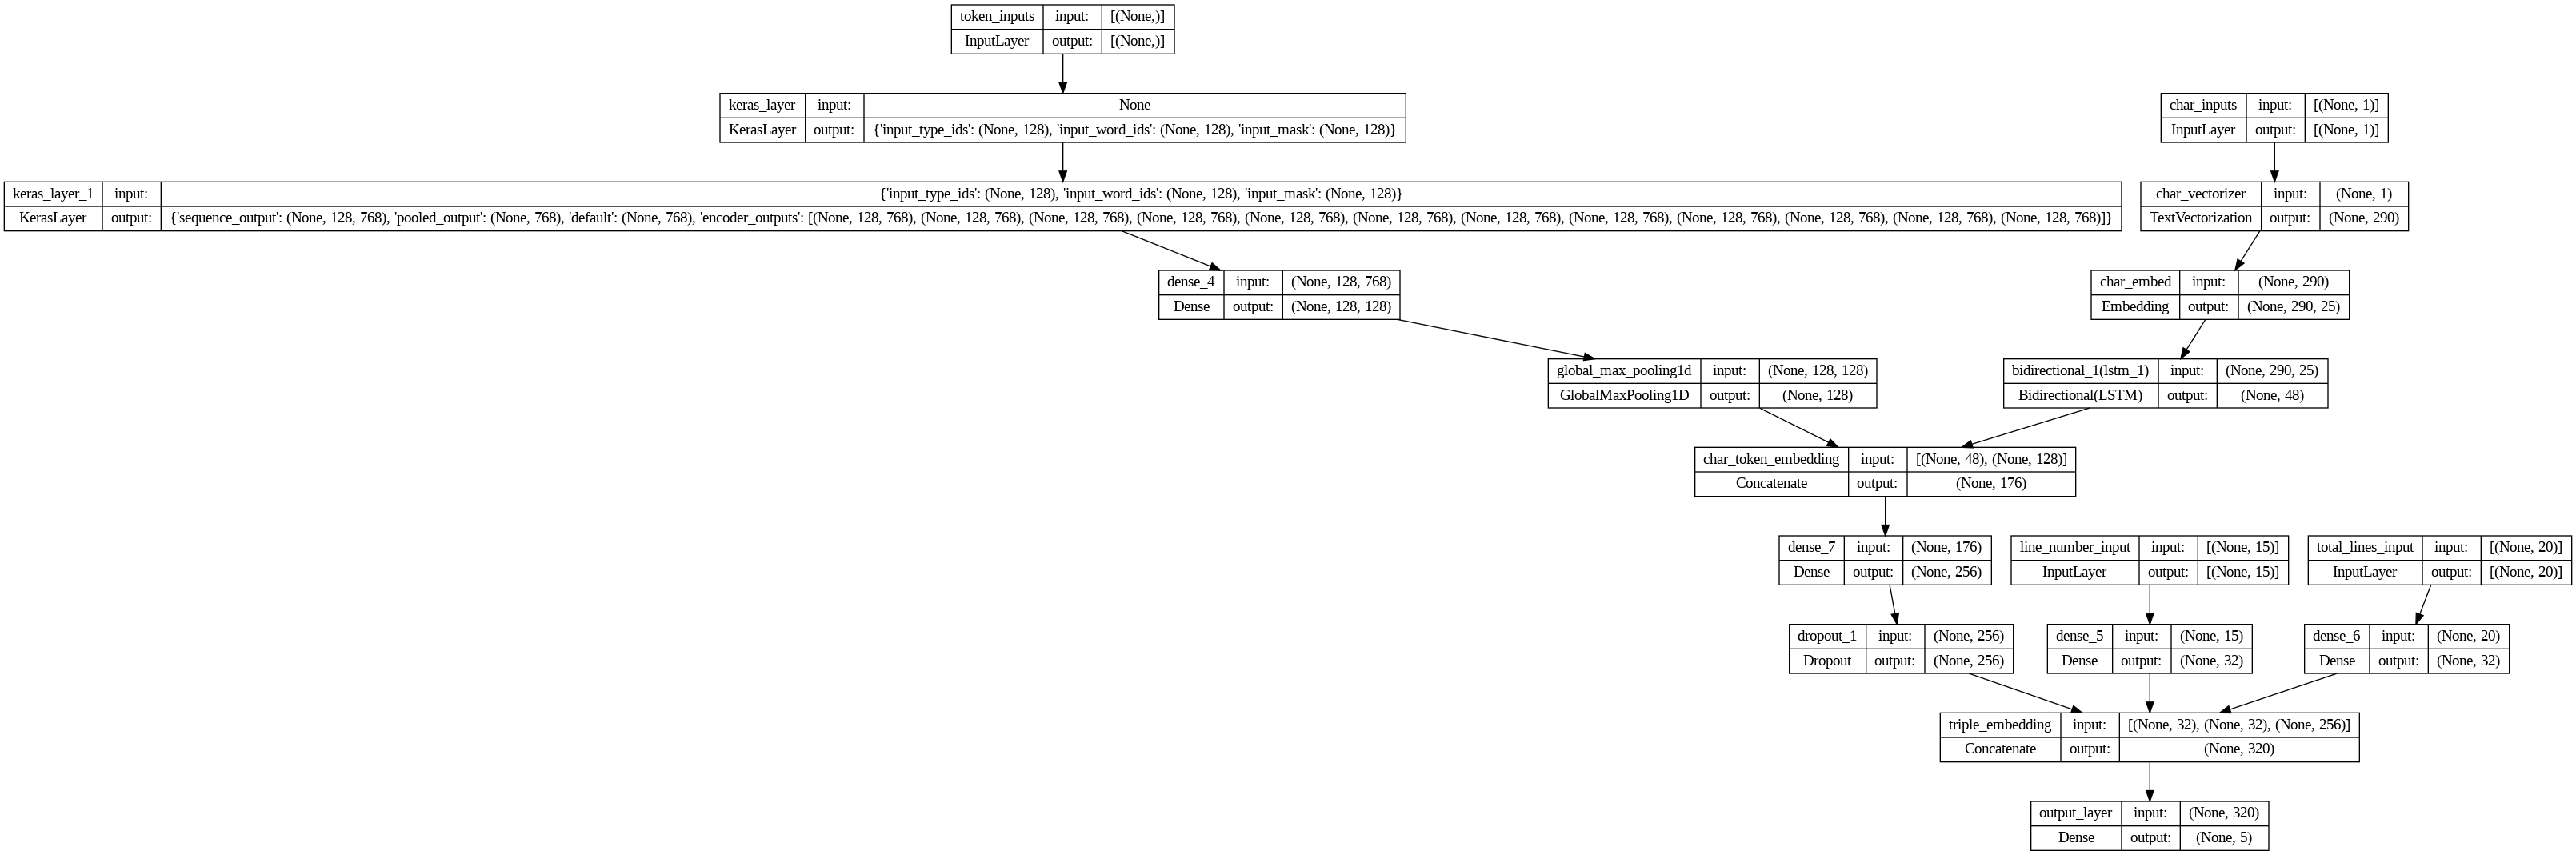

In [55]:
# Check the architecture
tf.keras.utils.plot_model(model_5_bert,
                          show_shapes=True)

In [59]:
# Compile the model_5_bert
model_5_bert.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [60]:
# Fit the BERT-enhanced model_5
history_model_5_bert = model_5_bert.fit(x=train_ln_tl_char_token_dataset,
                                        epochs=20,
                                        steps_per_epoch=int(0.1*(len(train_ln_tl_char_token_dataset))),
                                        validation_data=val_ln_tl_char_token_dataset,
                                        validation_steps=int(0.1*len(val_ln_tl_char_token_dataset)),
                                        callbacks=[early_stopping])

Epoch 1/20
562/562 [==============================] - 235s 398ms/step - loss: 0.8882 - accuracy: 0.8769 - val_loss: 0.8548 - val_accuracy: 0.8850
Epoch 2/20
562/562 [==============================] - 220s 392ms/step - loss: 0.8688 - accuracy: 0.8877 - val_loss: 0.8531 - val_accuracy: 0.8896
Epoch 3/20
562/562 [==============================] - 221s 393ms/step - loss: 0.8650 - accuracy: 0.8833 - val_loss: 0.8509 - val_accuracy: 0.8833
Epoch 4/20
562/562 [==============================] - 232s 413ms/step - loss: 0.8619 - accuracy: 0.8910 - val_loss: 0.8457 - val_accuracy: 0.8910
Epoch 5/20
562/562 [==============================] - 221s 393ms/step - loss: 0.8608 - accuracy: 0.8888 - val_loss: 0.8363 - val_accuracy: 0.8953
Epoch 6/20
562/562 [==============================] - 220s 392ms/step - loss: 0.8640 - accuracy: 0.8877 - val_loss: 0.8370 - val_accuracy: 0.8956
Epoch 7/20
562/562 [==============================] - 221s 394ms/step - loss: 0.8547 - accuracy: 0.8899 - val_loss: 0.8362 -

562/562 [==============================] - 33s 58ms/step - loss: 0.8837 - accuracy: 0.8850 - val_loss: 0.8543 - val_accuracy: 0.8830


In [61]:
from helper_functions import calculate_results
bert_preds = tf.argmax(model_5_bert.predict(val_ln_tl_char_token_dataset), axis=1)
results_bert = calculate_results(y_true=val_labels_encoded,
                                 y_pred=bert_preds)
results_bert

945/945 [==============================] - 307s 320ms/step


{'accuracy': 88.68330464716007,
 'precision': 0.8877561542945497,
 'recall': 0.8868330464716007,
 'f1': 0.8833713143730126}

### Conclusion - exercise 3
As supposed, the BERT-enhanced `model_5` was the best amongst all remaining ones we've built yet. I achieved results close to 90% in both *accuracy* and *F1-score* with a `val_loss` at the level of 0.83 compared to 0.88 for previous models (which is approx. 10% better in comparison).

Turns out that the state-of-the-art transformer architecture does its job and elevates model's performance even more.
